# Load the data

## Importing dataset to devite it between train and test datasets.

In [ ]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3) (50000, 1)
Test data shape: (10000, 32, 32, 3) (10000, 1)


## Using first 500 training images and the first 100 test images of each class

In [ ]:
import numpy as np

X_train_filtered = []
y_train_filtered = []
X_test_filtered = []
y_test_filtered = []

# Loop through each class
for class_label in range(10):
    train_indices = np.where(y_train.flatten() == class_label)[0][:500] # 500 images for each class for training purposes
    test_indices = np.where(y_test.flatten() == class_label)[0][:100] # 100 images for each class for test purposes.

    #data to the filtered arrays
    X_train_filtered.append(X_train[train_indices])
    y_train_filtered.append(y_train[train_indices])
    X_test_filtered.append(X_test[test_indices])
    y_test_filtered.append(y_test[test_indices])

# print("X_train: " , X_train_filtered)
# print("y_train: " , y_train_filtered)
# print("X_test: " , X_test_filtered)
# print("y_test: " , y_test_filtered)

# concatenating lists to form final arrays
X_train_filtered = np.concatenate(X_train_filtered)
y_train_filtered = np.concatenate(y_train_filtered)
X_test_filtered = np.concatenate(X_test_filtered)
y_test_filtered = np.concatenate(y_test_filtered)

# the shapes of the filtered datasets
print("training data shape:", X_train_filtered.shape, y_train_filtered.shape)
print("test data shape:", X_test_filtered.shape, y_test_filtered.shape)


training data shape: (5000, 32, 32, 3) (5000, 1)
test data shape: (1000, 32, 32, 3) (1000, 1)


## Here we do:
1.   Resizing
and
2.   Normalizing

** imageNet means and std were taken from:
[stack-overflow](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)

In [ ]:
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

# now appling the transformation to the training and test sets
X_train_normalized = torch.stack([transform(img) for img in X_train_filtered])
X_test_normalized = torch.stack([transform(img) for img in X_test_filtered])

print("Training data shape after transformation:", X_train_normalized.shape)
print("Test data shape after transformation:", X_test_normalized.shape)


Training data shape after transformation: torch.Size([5000, 3, 224, 224])
Test data shape after transformation: torch.Size([1000, 3, 224, 224])


## Now we can extract features using ResNet-18

device will be selected based on GPU and CPU. original code: [Pytorch website](https://discuss.pytorch.org/t/torch-cuda-is-available-is-true-while-i-am-using-the-gpu/29470)



how to use pretrained resnet and evalute it, was taken from [Stack-Overflow](https://stackoverflow.com/questions/46167566/pytorch-pre-trained-resnet18-model)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # taken from pytorch

resnet18 = resnet18(pretrained=True).to(device)
resnet18.eval()  # stackoverflow code


batch_size = 32 # with higher batch size, my colab environment crashes...
train_dataset = TensorDataset(X_train_normalized)
test_dataset = TensorDataset(X_test_normalized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to extract features in batches
def extract_features_in_batches(model, loader):
    all_features = []
    for batch in loader:
        data = batch[0].to(device)  # Move data to the same device as the model
        with torch.no_grad():  # No gradient computation for inference
            features = model(data).squeeze()  # Extract features
        all_features.append(features.cpu())  # Move to CPU to free GPU memory
    return torch.cat(all_features)

# Now we extract features for training and test sets
X_train_features = extract_features_in_batches(resnet18, train_loader)
X_test_features = extract_features_in_batches(resnet18, test_loader)

print("Feature extraction complete with batch processing.")
print("Training features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.4MB/s]


## Final task for Dataset overview, PCA Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

# Appling PCA on the training and test feature sets
X_train_pca = pca.fit_transform(X_train_features.cpu().numpy())
X_test_pca = pca.transform(X_test_features.cpu().numpy())

print("Training features shape after PCA:", X_train_pca.shape)
print("Test features shape after PCA:", X_test_pca.shape)

# Naive Bayes:

## Custom Gaussian Naive Bayes Implementation

idea was taken from:
1. [StackOverflow](https://stackoverflow.com/questions/60189467/class-asks-me-to-give-self-for-naive-bayes-model-python)
2. [Scikit-learn's naive_bayes class](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/naive_bayes.py)


** Also Google GEMINI Suggeted some codes(like co-pilot) while writing it on colab environment.

In [ ]:
import numpy as np

class GaussianNaiveBayes:
    def __init__(self) -> None:
        self.means = None
        self.variances = None
        self.priors = None

    def fit(self, X, y) -> None:
        self.classes = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes)

        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.means[idx, :] = X_cls.mean(axis=0)
            self.variances[idx, :] = X_cls.var(axis=0) + 1e-9  # Added small value to avoid division by zero ** This idea is from GOOGLE GEMINI.
            self.priors[idx] = X_cls.shape[0] / X.shape[0]

    def predict(self, X) -> np.ndarray:
        posteriors = np.zeros((X.shape[0], len(self.classes)))

        for idx, cls in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.variances[idx, :]))
            likelihood -= 0.5 * np.sum(((X - self.means[idx, :]) ** 2) / self.variances[idx, :], axis=1)
            posteriors[:, idx] = prior + likelihood

        return self.classes[np.argmax(posteriors, axis=1)]

gnb_custom = GaussianNaiveBayes()
gnb_custom.fit(X_train_pca, y_train_filtered.flatten())  # Flatten y_train for compatibility


y_pred_custom = gnb_custom.predict(X_test_pca)
print("Custom Gaussian Naive Bayes completed.")

Custom Gaussian Naive Bayes completed.


## Gaussian Naive Bayes Using Scikit-Learn


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb_sklearn = GaussianNB()
gnb_sklearn.fit(X_train_pca, y_train_filtered.flatten())

y_pred_sklearn = gnb_sklearn.predict(X_test_pca)
print("Scikit-learn Gaussian Naive Bayes completed.")

Scikit-learn Gaussian Naive Bayes completed.


## Evaluate both of these models on the test set.


Custom GNB Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       100
           1       0.90      0.86      0.88       100
           2       0.75      0.63      0.68       100
           3       0.62      0.70      0.66       100
           4       0.70      0.74      0.72       100
           5       0.72      0.68      0.70       100
           6       0.75      0.83      0.79       100
           7       0.84      0.78      0.81       100
           8       0.86      0.82      0.84       100
           9       0.85      0.90      0.87       100

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000


Scikit-learn GNB Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       100
           1       0.90      0.86      0.88       100
  

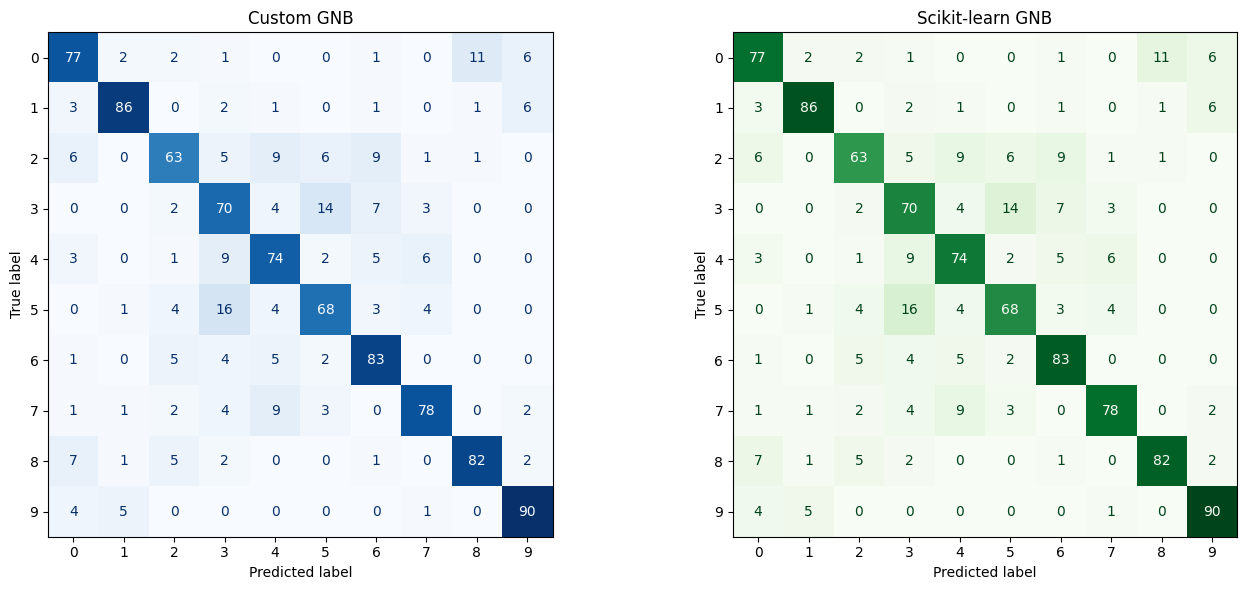

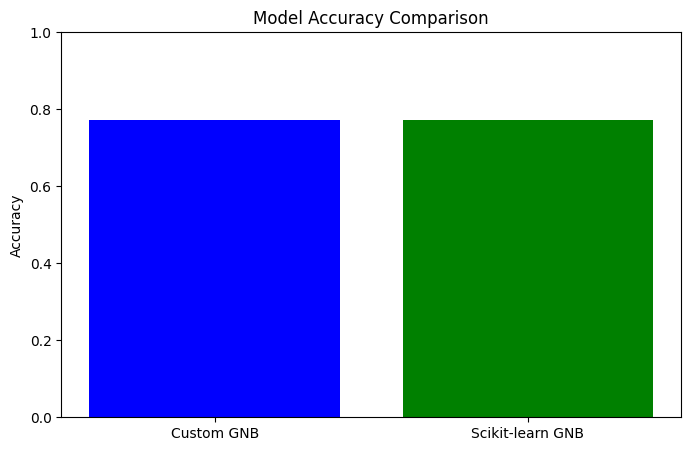

Model saved to naive_bayes_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy_custom = accuracy_score(y_test_filtered.flatten(), y_pred_custom)
accuracy_sklearn = accuracy_score(y_test_filtered.flatten(), y_pred_sklearn)

print("\nCustom GNB Classification Report:")
print(classification_report(y_test_filtered.flatten(), y_pred_custom))

print("\nScikit-learn GNB Classification Report:")
print(classification_report(y_test_filtered.flatten(), y_pred_sklearn))


fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # confussion matrix

ConfusionMatrixDisplay.from_predictions(
    y_test_filtered.flatten(),
    y_pred_custom,
    ax=axes[0],
    cmap="Blues",
    colorbar=False
)
axes[0].set_title("Custom GNB")

ConfusionMatrixDisplay.from_predictions(
    y_test_filtered.flatten(),
    y_pred_sklearn,
    ax=axes[1],
    cmap="Greens",
    colorbar=False
)
axes[1].set_title("Scikit-learn GNB")

plt.tight_layout()
plt.show()

models = ['Custom GNB', 'Scikit-learn GNB']
accuracies = [accuracy_custom, accuracy_sklearn]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


# now i save the naive_bayes_model::
import pickle
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(gnb_custom, f)
    print("Model saved to naive_bayes_model.pkl")
from google.colab import files
files.download('naive_bayes_model.pkl')

# Section 4: Decision Tree.

## Custom Decision Tree Classifier (Gini Index, Max Depth = 50)

the idea was taken from:
[Ander Fernandez's blog](https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/) and
[Medium.com](https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836)

In [ ]:
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    def gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / m
        return 1 - np.sum(probabilities ** 2)

    def split(self, X, y, feature, threshold):
        left_indices = X[:, feature] < threshold
        right_indices = ~left_indices
        return X[left_indices], y[left_indices], X[right_indices], y[right_indices]

    def best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None
        parent_gini = self.gini(y)
        best_gain = 0
        best_split_feature, best_split_threshold = None, None
        for feature in range(n):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self.split(X, y, feature, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                n_left, n_right = len(y_left), len(y_right)
                child_gini = (n_left / m) * self.gini(y_left) + (n_right / m) * self.gini(y_right)
                gain = parent_gini - child_gini
                if gain > best_gain:
                    best_gain = gain
                    best_split_feature, best_split_threshold = feature, threshold
        return best_split_feature, best_split_threshold

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(y))
        feature, threshold = self.best_split(X, y)
        if feature is None:
            return np.argmax(np.bincount(y))
        X_left, y_left, X_right, y_right = self.split(X, y, feature, threshold)
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X_left, y_left, depth + 1),
            'right': self.build_tree(X_right, y_right, depth + 1),
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            if sample[tree['feature']] < tree['threshold']:
                return self.predict_sample(sample, tree['left'])
            else:
                return self.predict_sample(sample, tree['right'])
        else:
            return tree

    def predict(self, X):
        return np.array([self.predict_sample(sample, self.tree) for sample in X])

## Train the tree:

In [ ]:
custom_tree = DecisionTreeClassifier(max_depth=50)
custom_tree.fit(X_train_pca, y_train_filtered.flatten())

## Save the model:

** code suggested by GOOGLE GEMINI. propt was: I want to download my custom dicision tree.

In [ ]:
import cloudpickle

# Save the custom tree model using cloudpickle
with open('dtc_cloudpickle.pkl', 'wb') as f:
    cloudpickle.dump(custom_tree, f)

print("Model saved to dtc_cloudpickle.pkl")

# Download the model file
from google.colab import files
files.download('dtc_cloudpickle.pkl')


Model saved to dtc_cloudpickle.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predict on Test Set:


In [ ]:
y_pred_custom_tree = custom_tree.predict(X_test_pca)

## Experimenting with Different Depths

Tree Depth: 5, Accuracy: 0.5850
Tree Depth: 10, Accuracy: 0.6030
Tree Depth: 15, Accuracy: 0.5800
Tree Depth: 20, Accuracy: 0.5780
Tree Depth: 35, Accuracy: 0.5780
Tree Depth: 50, Accuracy: 0.5780


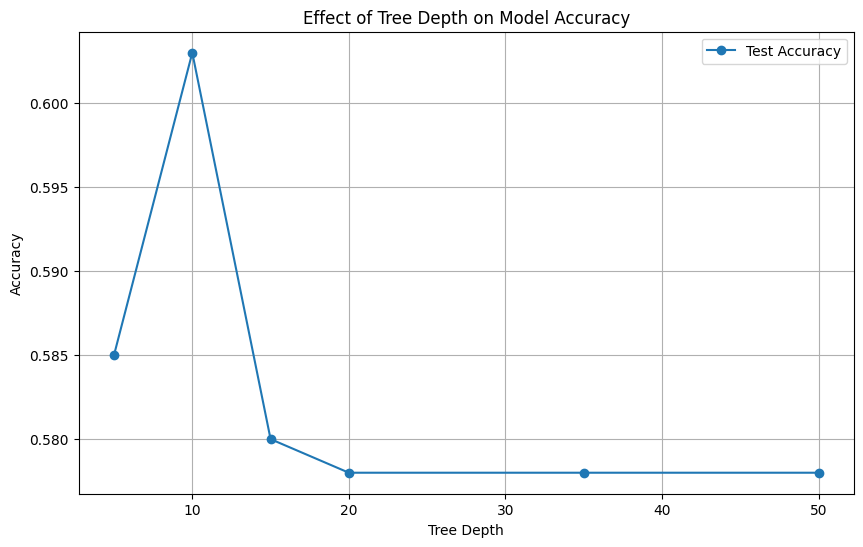

In [ ]:
depths = [5, 10, 15, 20, 35, 50]  # We will experiment with 6 depts from 5 to 50
accuracies_for_custome_tree = []

for depth in depths:
    custom_tree = DecisionTreeClassifier(max_depth=depth)
    custom_tree.fit(X_train_pca, y_train_filtered.flatten())

    y_pred = custom_tree.predict(X_test_pca)
    #print(y_pred)

    accuracy = np.mean(y_pred == y_test_filtered.flatten())

    accuracies_for_custome_tree.append(accuracy)
    print(f"Tree Depth: {depth}, Accuracy: {accuracy:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies_for_custome_tree, marker='o', label='Test Accuracy')
plt.title("Effect of Tree Depth on Model Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


## Scikit-learn's DecisionTreeClassifier

Tree Depth: 5, Accuracy: 0.5860
Tree Depth: 10, Accuracy: 0.6100
Tree Depth: 15, Accuracy: 0.6050
Tree Depth: 20, Accuracy: 0.6000
Tree Depth: 35, Accuracy: 0.6000
Tree Depth: 50, Accuracy: 0.6000


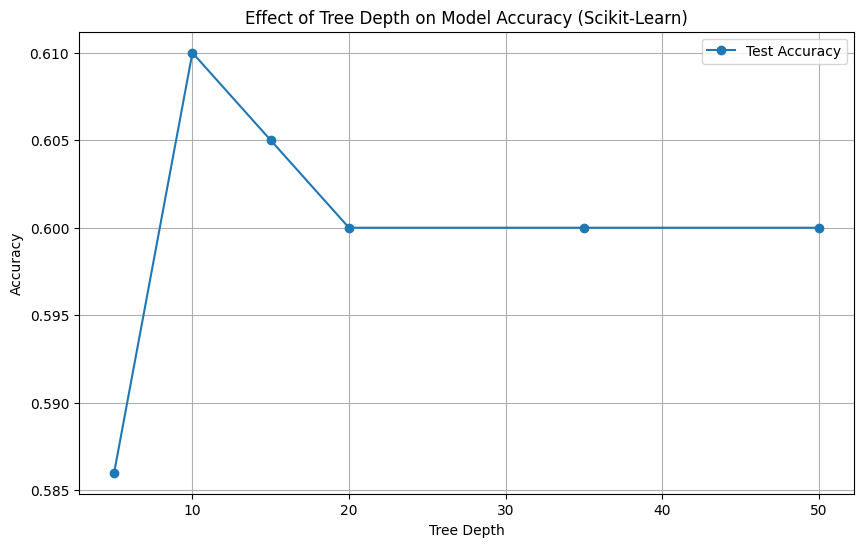

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracies_for_sklearn_tree = []

for depth in depths:
    sk_tree = DecisionTreeClassifier(criterion="gini", max_depth=depth, random_state=42)
    sk_tree.fit(X_train_pca, y_train_filtered.flatten())

    y_pred_sklearn_tree = sk_tree.predict(X_test_pca)

    accuracy = accuracy_score(y_test_filtered.flatten(), y_pred_sklearn_tree)
    accuracies_for_sklearn_tree.append(accuracy)
    print(f"Tree Depth: {depth}, Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies_for_sklearn_tree, marker='o', label='Test Accuracy')
plt.title("Effect of Tree Depth on Model Accuracy (Scikit-Learn)")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## Evaluation and Graphical Comparison


Custom Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       100
           1       0.73      0.72      0.72       100
           2       0.43      0.40      0.42       100
           3       0.42      0.43      0.42       100
           4       0.48      0.53      0.50       100
           5       0.56      0.61      0.59       100
           6       0.67      0.69      0.68       100
           7       0.49      0.48      0.48       100
           8       0.63      0.63      0.63       100
           9       0.80      0.74      0.77       100

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000


Scikit-Learn Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       100
           1       0.78      0.77    

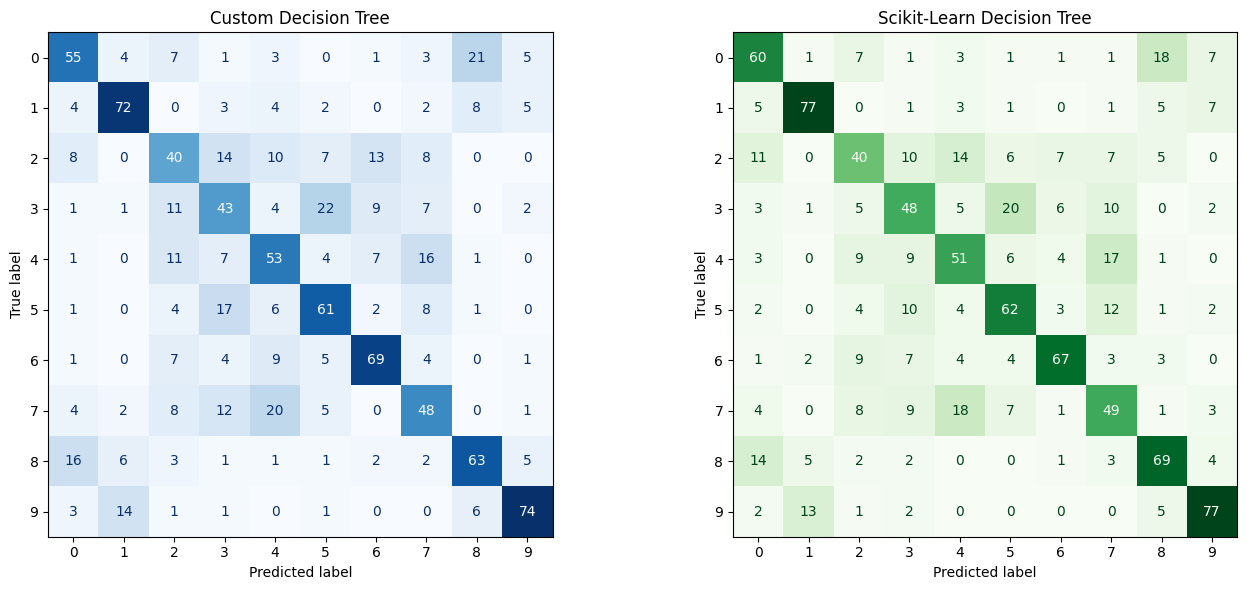

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("Custom Decision Tree Classification Report:")
print(classification_report(y_test_filtered.flatten(), y_pred_custom_tree))

print("\nScikit-Learn Decision Tree Classification Report:")
print(classification_report(y_test_filtered.flatten(), y_pred_sklearn_tree))

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # for plotting confussion matrix

ConfusionMatrixDisplay.from_predictions(
    y_test_filtered.flatten(),
    y_pred_custom_tree,
    ax=axes[0],
    cmap="Blues",
    colorbar=False
)
axes[0].set_title("Custom Decision Tree")

# Scikit-Learn Decision Tree confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_filtered.flatten(),
    y_pred_sklearn_tree,
    ax=axes[1],
    cmap="Greens",
    colorbar=False
)
axes[1].set_title("Scikit-Learn Decision Tree")

plt.tight_layout()
plt.show()


# MLP

## Implementation of the specified three-layer MLP using PyTorch:

Help taken from:
[pytorch discussion](https://)
and [medium.com](https://medium.com/@hirok4/building-a-multi-layer-perceptron-from-scratch-c9679752cf48)

I just ignored the layers part. as we need to implement three-layerd MLP.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

batch_size = 32

train_dataset = TensorDataset(torch.tensor(X_train_pca, dtype=torch.float32),
                               torch.tensor(y_train_filtered.flatten(), dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_pca, dtype=torch.float32),
                              torch.tensor(y_test_filtered.flatten(), dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 100
for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mlp_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

#now we save the model:
## Code suggested by Google GEMINI.

torch.save(mlp_model.state_dict(), 'mlp_model.pth')
print("Model saved to mlp_model.pth")
# Download the model file
from google.colab import files
files.download('mlp_model.pth')

Epoch [1/100], Loss: 0.7630
Epoch [2/100], Loss: 0.4977
Epoch [3/100], Loss: 0.4154
Epoch [4/100], Loss: 0.3474
Epoch [5/100], Loss: 0.2800
Epoch [6/100], Loss: 0.2395
Epoch [7/100], Loss: 0.2013
Epoch [8/100], Loss: 0.1643
Epoch [9/100], Loss: 0.1387
Epoch [10/100], Loss: 0.1264
Epoch [11/100], Loss: 0.1120
Epoch [12/100], Loss: 0.1001
Epoch [13/100], Loss: 0.0788
Epoch [14/100], Loss: 0.0809
Epoch [15/100], Loss: 0.0500
Epoch [16/100], Loss: 0.0508
Epoch [17/100], Loss: 0.0418
Epoch [18/100], Loss: 0.0285
Epoch [19/100], Loss: 0.0313
Epoch [20/100], Loss: 0.0251
Epoch [21/100], Loss: 0.0174
Epoch [22/100], Loss: 0.0191
Epoch [23/100], Loss: 0.0149
Epoch [24/100], Loss: 0.0145
Epoch [25/100], Loss: 0.0113
Epoch [26/100], Loss: 0.0101
Epoch [27/100], Loss: 0.0081
Epoch [28/100], Loss: 0.0061
Epoch [29/100], Loss: 0.0053
Epoch [30/100], Loss: 0.0048
Epoch [31/100], Loss: 0.0044
Epoch [32/100], Loss: 0.0047
Epoch [33/100], Loss: 0.0063
Epoch [34/100], Loss: 0.0053
Epoch [35/100], Loss: 0

## experiment by varying the depth of the MLP and document the influence on performance:

Epoch [1/10], Depth: 2, Loss: 0.8791, Accuracy: 0.7740
Epoch [2/10], Depth: 2, Loss: 0.5201, Accuracy: 0.7740
Epoch [3/10], Depth: 2, Loss: 0.4757, Accuracy: 0.8060
Epoch [4/10], Depth: 2, Loss: 0.4122, Accuracy: 0.8180
Epoch [5/10], Depth: 2, Loss: 0.3724, Accuracy: 0.8050
Epoch [6/10], Depth: 2, Loss: 0.3435, Accuracy: 0.7980
Epoch [7/10], Depth: 2, Loss: 0.3285, Accuracy: 0.8240
Epoch [8/10], Depth: 2, Loss: 0.2791, Accuracy: 0.8160
Epoch [9/10], Depth: 2, Loss: 0.2768, Accuracy: 0.8160
Epoch [10/10], Depth: 2, Loss: 0.2468, Accuracy: 0.8170
Final Depth: 2, Test Accuracy: 0.8170
Epoch [1/10], Depth: 3, Loss: 1.1277, Accuracy: 0.7630
Epoch [2/10], Depth: 3, Loss: 0.6654, Accuracy: 0.7840
Epoch [3/10], Depth: 3, Loss: 0.5618, Accuracy: 0.8000
Epoch [4/10], Depth: 3, Loss: 0.5083, Accuracy: 0.8140
Epoch [5/10], Depth: 3, Loss: 0.4646, Accuracy: 0.8180
Epoch [6/10], Depth: 3, Loss: 0.4313, Accuracy: 0.8170
Epoch [7/10], Depth: 3, Loss: 0.4111, Accuracy: 0.8290
Epoch [8/10], Depth: 3, Lo

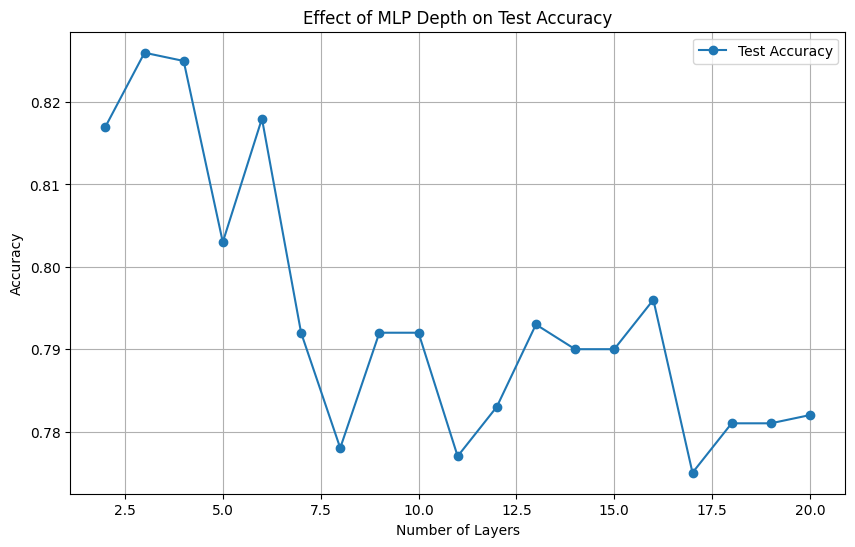

In [ ]:
class MLPVariant(nn.Module):
    def __init__(self, depth):
        super(MLPVariant, self).__init__()
        layers = []


        layers.append(nn.Linear(50, 512))
        layers.append(nn.ReLU())


        for _ in range(depth - 2):  # -2 to account for input and output layers
            layers.append(nn.Linear(512, 512))
            layers.append(nn.BatchNorm1d(512))
            layers.append(nn.ReLU())


        layers.append(nn.Linear(512, 10))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

depths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20]
accuracies = []

for depth in depths:
    model = MLPVariant(depth).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Depth: {depth}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

    accuracies.append(accuracy)
    print(f"Final Depth: {depth}, Test Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', label="Test Accuracy")
plt.title("Effect of MLP Depth on Test Accuracy")
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## This time we vary the sizes of the hidden layers. And experiment with larger and smaller sizes.  And then we analyze the trade-offs in computational cost and performance of the model.

Epoch [1/10], Hidden Size: 64, Loss: 1.7655
Epoch [2/10], Hidden Size: 64, Loss: 1.1582
Epoch [3/10], Hidden Size: 64, Loss: 0.9146
Epoch [4/10], Hidden Size: 64, Loss: 0.7936
Epoch [5/10], Hidden Size: 64, Loss: 0.7111
Epoch [6/10], Hidden Size: 64, Loss: 0.6553
Epoch [7/10], Hidden Size: 64, Loss: 0.6075
Epoch [8/10], Hidden Size: 64, Loss: 0.5684
Epoch [9/10], Hidden Size: 64, Loss: 0.5492
Epoch [10/10], Hidden Size: 64, Loss: 0.5329
Final Hidden Size: 64, Test Accuracy: 0.8090


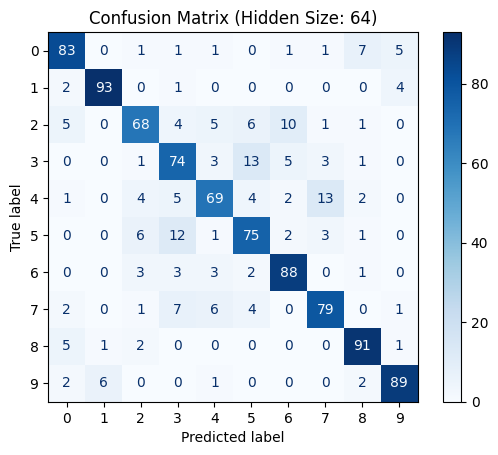

Epoch [1/10], Hidden Size: 128, Loss: 1.6121
Epoch [2/10], Hidden Size: 128, Loss: 0.9727
Epoch [3/10], Hidden Size: 128, Loss: 0.7769
Epoch [4/10], Hidden Size: 128, Loss: 0.6800
Epoch [5/10], Hidden Size: 128, Loss: 0.6201
Epoch [6/10], Hidden Size: 128, Loss: 0.5801
Epoch [7/10], Hidden Size: 128, Loss: 0.5453
Epoch [8/10], Hidden Size: 128, Loss: 0.5121
Epoch [9/10], Hidden Size: 128, Loss: 0.4885
Epoch [10/10], Hidden Size: 128, Loss: 0.4663
Final Hidden Size: 128, Test Accuracy: 0.8230


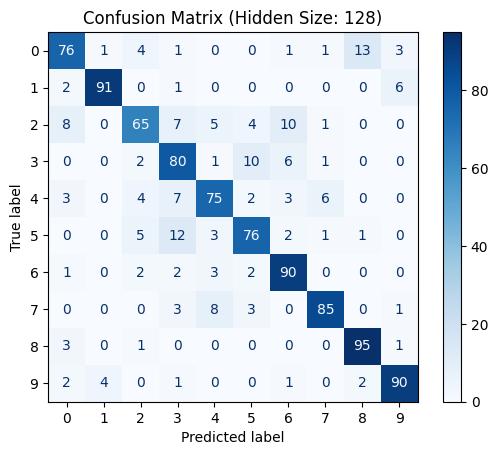

Epoch [1/10], Hidden Size: 256, Loss: 1.3531
Epoch [2/10], Hidden Size: 256, Loss: 0.7951
Epoch [3/10], Hidden Size: 256, Loss: 0.6702
Epoch [4/10], Hidden Size: 256, Loss: 0.5941
Epoch [5/10], Hidden Size: 256, Loss: 0.5484
Epoch [6/10], Hidden Size: 256, Loss: 0.5146
Epoch [7/10], Hidden Size: 256, Loss: 0.4852
Epoch [8/10], Hidden Size: 256, Loss: 0.4521
Epoch [9/10], Hidden Size: 256, Loss: 0.4314
Epoch [10/10], Hidden Size: 256, Loss: 0.4128
Final Hidden Size: 256, Test Accuracy: 0.8350


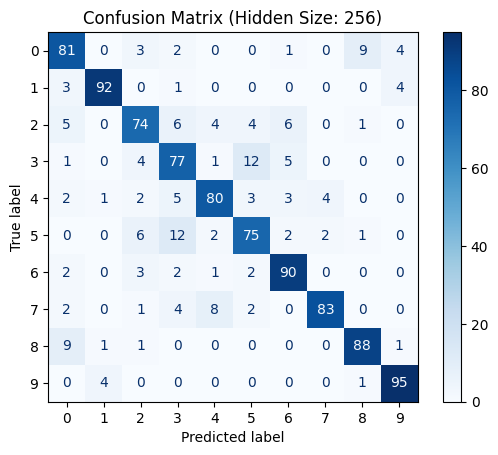

Epoch [1/10], Hidden Size: 512, Loss: 1.1041
Epoch [2/10], Hidden Size: 512, Loss: 0.6558
Epoch [3/10], Hidden Size: 512, Loss: 0.5735
Epoch [4/10], Hidden Size: 512, Loss: 0.5151
Epoch [5/10], Hidden Size: 512, Loss: 0.4691
Epoch [6/10], Hidden Size: 512, Loss: 0.4321
Epoch [7/10], Hidden Size: 512, Loss: 0.4069
Epoch [8/10], Hidden Size: 512, Loss: 0.3768
Epoch [9/10], Hidden Size: 512, Loss: 0.3569
Epoch [10/10], Hidden Size: 512, Loss: 0.3398
Final Hidden Size: 512, Test Accuracy: 0.8230


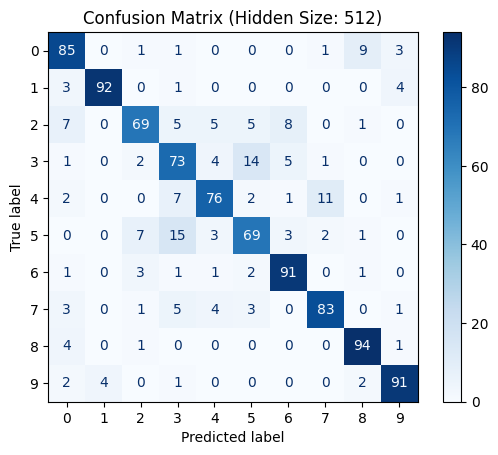

Epoch [1/10], Hidden Size: 1024, Loss: 0.9168
Epoch [2/10], Hidden Size: 1024, Loss: 0.5627
Epoch [3/10], Hidden Size: 1024, Loss: 0.4777
Epoch [4/10], Hidden Size: 1024, Loss: 0.4304
Epoch [5/10], Hidden Size: 1024, Loss: 0.3947
Epoch [6/10], Hidden Size: 1024, Loss: 0.3561
Epoch [7/10], Hidden Size: 1024, Loss: 0.3336
Epoch [8/10], Hidden Size: 1024, Loss: 0.2983
Epoch [9/10], Hidden Size: 1024, Loss: 0.2810
Epoch [10/10], Hidden Size: 1024, Loss: 0.2595
Final Hidden Size: 1024, Test Accuracy: 0.8250


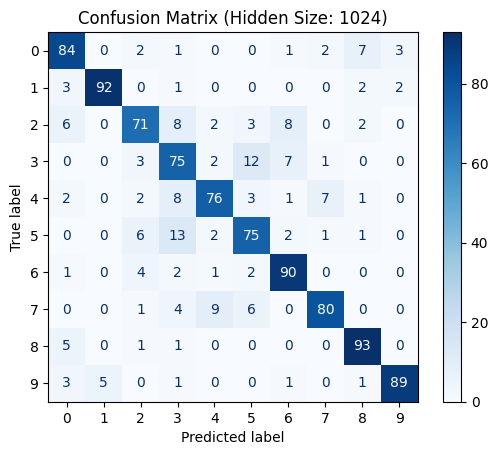

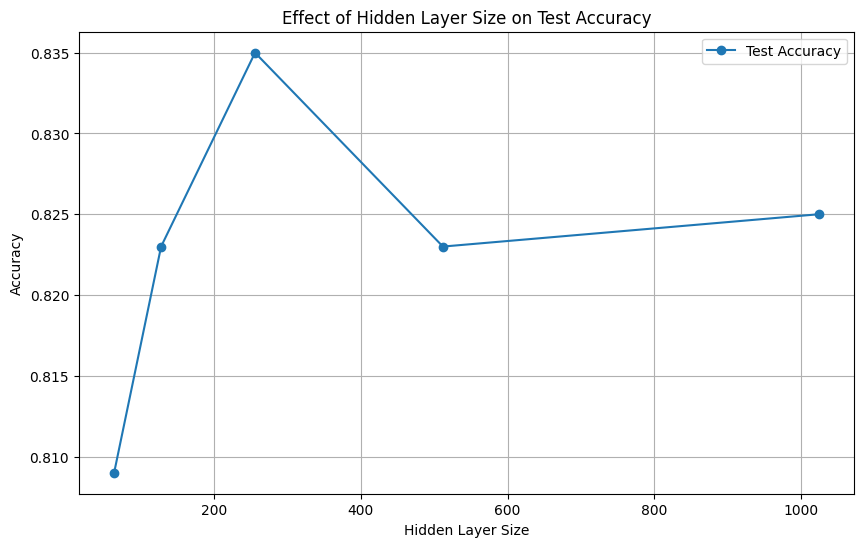

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

class MLPVariableHidden(nn.Module):
    def __init__(self, hidden_size):
        super(MLPVariableHidden, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.model(x)


hidden_sizes = [64, 128, 256, 512, 1024]
accuracies = []


for hidden_size in hidden_sizes:

    model = MLPVariableHidden(hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Hidden Size: {hidden_size}, Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Final Hidden Size: {hidden_size}, Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Hidden Size: {hidden_size})')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, accuracies, marker='o', label='Test Accuracy')
plt.title('Effect of Hidden Layer Size on Test Accuracy')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#CNN

## Define the VGG11 Class
idea taken from:
[debugger cafe](https://debuggercafe.com/implementing-vgg11-from-scratch-using-pytorch/)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self._to_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


## Data Loading and Preprocessing

In [6]:
import numpy as np

def cifar_loader(batch_size, num_train_per_class=500, num_test_per_class=100):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_set = datasets.CIFAR10('./data', train=True, download=True,
                                 transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                                               transforms.RandomCrop(32, 4),
                                                               transforms.ToTensor(), normalize]))

    test_set = datasets.CIFAR10('./data', train=False, download=True,
                                transform=transforms.Compose([transforms.ToTensor(), normalize]))

    # only include the first 500 images per class for training and 100 for testing
    train_indices = []
    test_indices = []

    for class_label in range(10):
        train_class_indices = np.where(np.array(train_set.targets) == class_label)[0][:num_train_per_class]
        test_class_indices = np.where(np.array(test_set.targets) == class_label)[0][:num_test_per_class]

        train_indices.extend(train_class_indices)
        test_indices.extend(test_class_indices)

    train_subset = torch.utils.data.Subset(train_set, train_indices)
    test_subset = torch.utils.data.Subset(test_set, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, test_loader

batch_size = 64
train_loader, test_loader = cifar_loader(batch_size)


100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Inititialize the model.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG11().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training the model

In [8]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/30], Loss: 2.0166, Accuracy: 24.54%
Epoch [2/30], Loss: 1.7939, Accuracy: 34.16%
Epoch [3/30], Loss: 1.6040, Accuracy: 39.38%
Epoch [4/30], Loss: 1.4678, Accuracy: 46.26%
Epoch [5/30], Loss: 1.3800, Accuracy: 50.10%
Epoch [6/30], Loss: 1.3180, Accuracy: 52.98%
Epoch [7/30], Loss: 1.2758, Accuracy: 55.14%
Epoch [8/30], Loss: 1.2064, Accuracy: 57.48%
Epoch [9/30], Loss: 1.1799, Accuracy: 59.04%
Epoch [10/30], Loss: 1.1493, Accuracy: 59.76%
Epoch [11/30], Loss: 1.0154, Accuracy: 63.98%
Epoch [12/30], Loss: 0.9843, Accuracy: 64.96%
Epoch [13/30], Loss: 0.9507, Accuracy: 66.84%
Epoch [14/30], Loss: 0.9103, Accuracy: 68.16%
Epoch [15/30], Loss: 0.8894, Accuracy: 69.92%
Epoch [16/30], Loss: 0.8477, Accuracy: 70.50%
Epoch [17/30], Loss: 0.7918, Accuracy: 73.24%
Epoch [18/30], Loss: 0.8004, Accuracy: 73.38%
Epoch [19/30], Loss: 0.7673, Accuracy: 73.24%
Epoch [20/30], Loss: 0.7453, Accuracy: 74.86%
Epoch [21/30], Loss: 0.7467, Accuracy: 74.86%
Epoch [22/30], Loss: 0.6601, Accuracy: 77.9

## Save the model:

code suggested by Google Gemini.

In [10]:
torch.save(model, 'vgg11_full_model.pth')
print("Full model saved to vgg11_full_model.pth")
from google.colab import files
files.download('vgg11_full_model.pth')

Full model saved to vgg11_full_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training loss and accuracy:

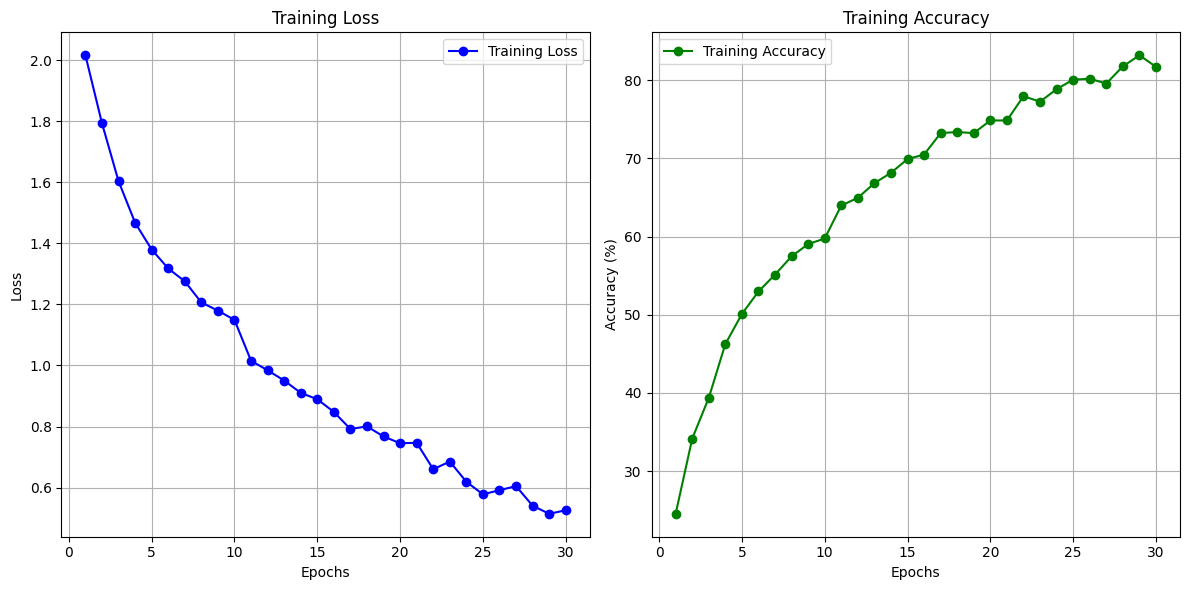

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Evalute the model:

Test Accuracy: 0.7040


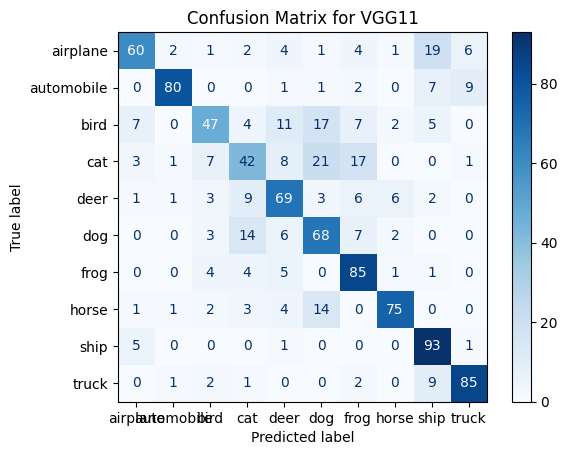

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)


cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix for VGG11')
plt.show()

## Experiment with the model by adding and removing laters.
we will define a custome VG11 class for this.

Files already downloaded and verified
Files already downloaded and verified

Training VGG_Light...
Epoch [1/30], Loss: 2.0073
Epoch [2/30], Loss: 1.7059
Epoch [3/30], Loss: 1.6278
Epoch [4/30], Loss: 1.5147
Epoch [5/30], Loss: 1.4475
Epoch [6/30], Loss: 1.3815
Epoch [7/30], Loss: 1.3442
Epoch [8/30], Loss: 1.2764
Epoch [9/30], Loss: 1.2258
Epoch [10/30], Loss: 1.2398
Epoch [11/30], Loss: 1.1812
Epoch [12/30], Loss: 1.1641
Epoch [13/30], Loss: 1.0954
Epoch [14/30], Loss: 1.0569
Epoch [15/30], Loss: 1.0449
Epoch [16/30], Loss: 0.9909
Epoch [17/30], Loss: 0.9842
Epoch [18/30], Loss: 0.9685
Epoch [19/30], Loss: 0.9411
Epoch [20/30], Loss: 0.9059
Epoch [21/30], Loss: 0.8828
Epoch [22/30], Loss: 0.8675
Epoch [23/30], Loss: 0.8615
Epoch [24/30], Loss: 0.8204
Epoch [25/30], Loss: 0.7983
Epoch [26/30], Loss: 0.7795
Epoch [27/30], Loss: 0.7742
Epoch [28/30], Loss: 0.7298
Epoch [29/30], Loss: 0.7288
Epoch [30/30], Loss: 0.7435
VGG_Light Accuracy: 0.6660

Training VGG_Full...
Epoch [1/30], Loss: 2

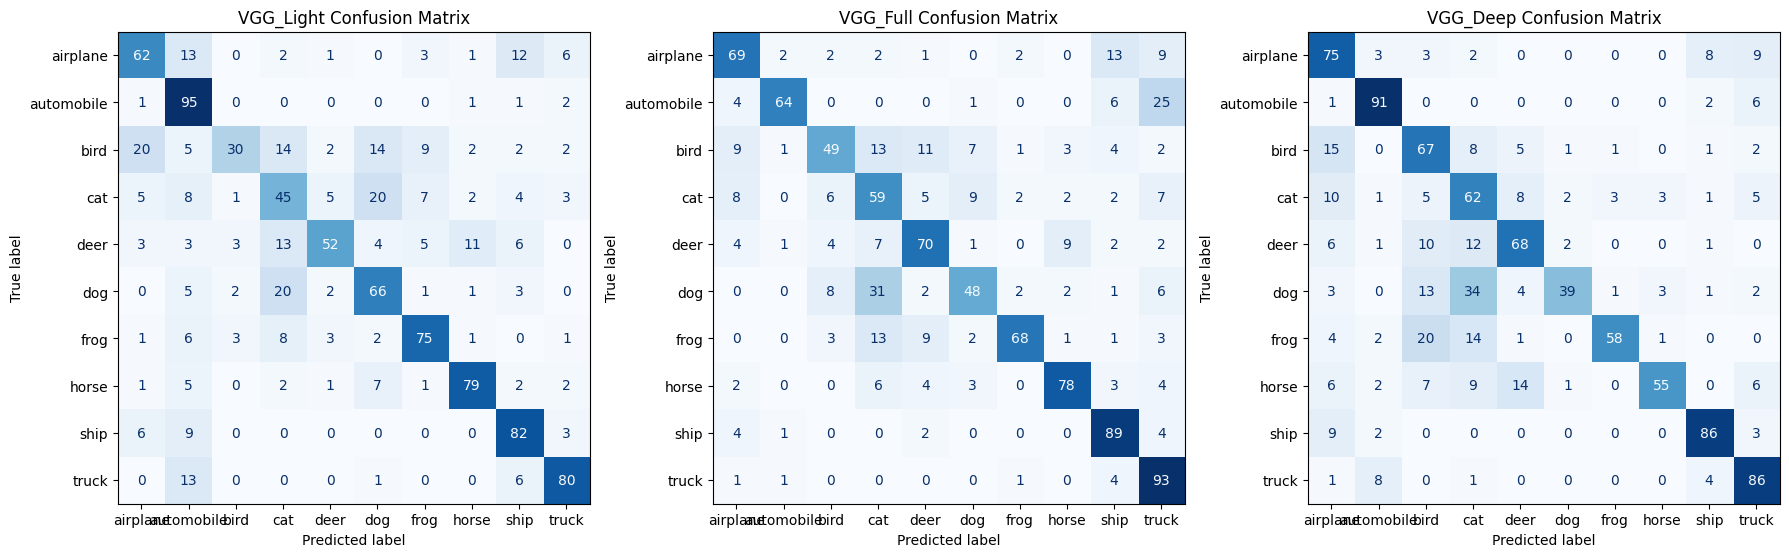

{'VGG_Light': {'accuracy': 0.666,
  'confusion_matrix': array([[62, 13,  0,  2,  1,  0,  3,  1, 12,  6],
         [ 1, 95,  0,  0,  0,  0,  0,  1,  1,  2],
         [20,  5, 30, 14,  2, 14,  9,  2,  2,  2],
         [ 5,  8,  1, 45,  5, 20,  7,  2,  4,  3],
         [ 3,  3,  3, 13, 52,  4,  5, 11,  6,  0],
         [ 0,  5,  2, 20,  2, 66,  1,  1,  3,  0],
         [ 1,  6,  3,  8,  3,  2, 75,  1,  0,  1],
         [ 1,  5,  0,  2,  1,  7,  1, 79,  2,  2],
         [ 6,  9,  0,  0,  0,  0,  0,  0, 82,  3],
         [ 0, 13,  0,  0,  0,  1,  0,  0,  6, 80]])},
 'VGG_Full': {'accuracy': 0.687,
  'confusion_matrix': array([[69,  2,  2,  2,  1,  0,  2,  0, 13,  9],
         [ 4, 64,  0,  0,  0,  1,  0,  0,  6, 25],
         [ 9,  1, 49, 13, 11,  7,  1,  3,  4,  2],
         [ 8,  0,  6, 59,  5,  9,  2,  2,  2,  7],
         [ 4,  1,  4,  7, 70,  1,  0,  9,  2,  2],
         [ 0,  0,  8, 31,  2, 48,  2,  2,  1,  6],
         [ 0,  0,  3, 13,  9,  2, 68,  1,  1,  3],
         [ 2,  0,  0,  

In [18]:
# modified VGG architectures (idea from : https://debuggercafe.com/implementing-vgg11-from-scratch-using-pytorch/)
class ModifiedVGG(nn.Module):
    def __init__(self, layers_config):
        super(ModifiedVGG, self).__init__()
        layers = []
        in_channels = 3
        for config in layers_config:
            if config == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, config, kernel_size=3, padding=1),
                    nn.BatchNorm2d(config),
                    nn.ReLU(inplace=True)
                ]
                in_channels = config
        self.features = nn.Sequential(*layers)

        def compute_fc_input_size(x):
            x = self.features(x)
            return x.view(x.size(0), -1)


        dummy_input = torch.zeros(1, 3, 32, 32)
        self.fc_input_size = compute_fc_input_size(dummy_input).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


layer_configs = {
    "VGG_Light": [64, 'M', 128, 'M', 256, 'M', 512, 'M'],
    "VGG_Full": [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    "VGG_Deep": [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M']
}


results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


batch_size = 64
train_loader, test_loader = cifar_loader(batch_size)

for name, config in layer_configs.items():
    print(f"\nTraining {name}...")
    model = ModifiedVGG(config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    results[name] = {'accuracy': acc, 'confusion_matrix': cm}
    print(f"{name} Accuracy: {acc:.4f}")


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for ax, (name, result) in zip(axes, results.items()):
    cm_display = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'], display_labels=class_names)
    cm_display.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()


results

## Modified VGG Class with Adjustable Kernel Sizes:

In [19]:
class ModifiedVGGWithKernels(nn.Module):
    def __init__(self, layers_config, kernel_size=3):
        super(ModifiedVGGWithKernels, self).__init__()
        layers = []
        in_channels = 3
        for config in layers_config:
            if config == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, config, kernel_size=kernel_size, padding=kernel_size//2),
                    nn.BatchNorm2d(config),
                    nn.ReLU(inplace=True)
                ]
                in_channels = config
        self.features = nn.Sequential(*layers)


        def compute_fc_input_size(x):
            x = self.features(x)
            return x.view(x.size(0), -1)

        dummy_input = torch.zeros(1, 3, 32, 32)
        self.fc_input_size = compute_fc_input_size(dummy_input).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Experiment with different Kernel sizes:


Training with kernel size 2x2...
Epoch [1/30], Loss: 2.0294
Epoch [2/30], Loss: 1.7207
Epoch [3/30], Loss: 1.5941
Epoch [4/30], Loss: 1.4886
Epoch [5/30], Loss: 1.3874
Epoch [6/30], Loss: 1.2860
Epoch [7/30], Loss: 1.2499
Epoch [8/30], Loss: 1.2234
Epoch [9/30], Loss: 1.1110
Epoch [10/30], Loss: 1.0813
Epoch [11/30], Loss: 1.0286
Epoch [12/30], Loss: 1.0063
Epoch [13/30], Loss: 1.0102
Epoch [14/30], Loss: 0.9751
Epoch [15/30], Loss: 0.8982
Epoch [16/30], Loss: 0.8473
Epoch [17/30], Loss: 0.8313
Epoch [18/30], Loss: 0.8252
Epoch [19/30], Loss: 0.7940
Epoch [20/30], Loss: 0.7541
Epoch [21/30], Loss: 0.7564
Epoch [22/30], Loss: 0.7800
Epoch [23/30], Loss: 0.6875
Epoch [24/30], Loss: 0.6764
Epoch [25/30], Loss: 0.7263
Epoch [26/30], Loss: 0.6769
Epoch [27/30], Loss: 0.6469
Epoch [28/30], Loss: 0.6247
Epoch [29/30], Loss: 0.5634
Epoch [30/30], Loss: 0.6033
Kernel size 2x2 Accuracy: 0.6890

Training with kernel size 3x3...
Epoch [1/30], Loss: 1.9915
Epoch [2/30], Loss: 1.7314
Epoch [3/30], 

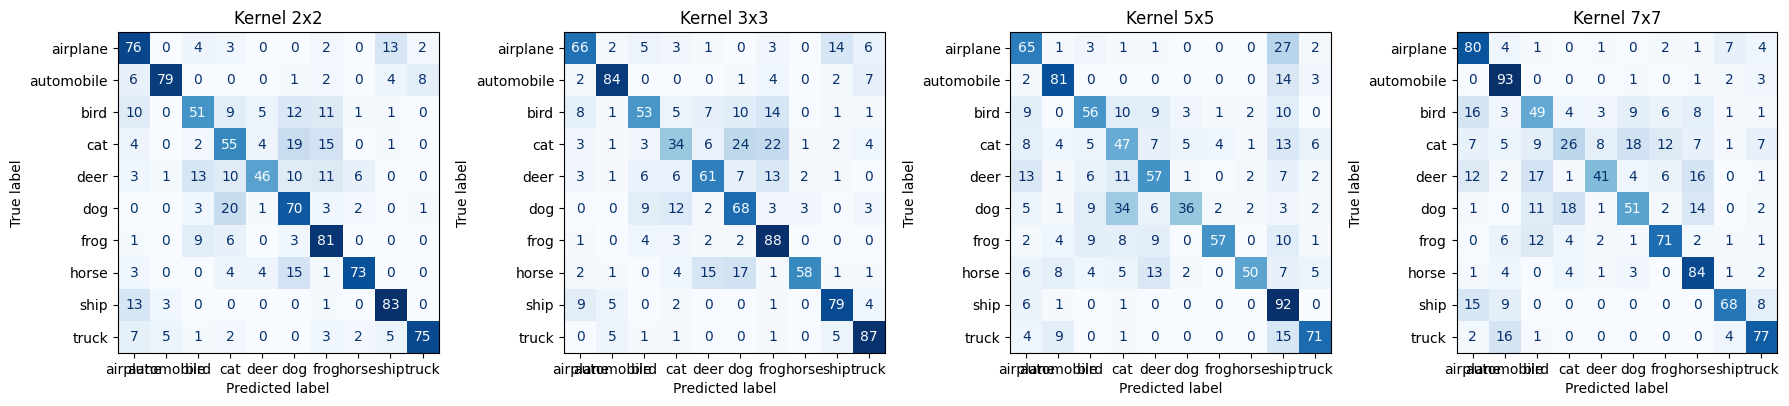

{2: {'accuracy': 0.689,
  'confusion_matrix': array([[76,  0,  4,  3,  0,  0,  2,  0, 13,  2],
         [ 6, 79,  0,  0,  0,  1,  2,  0,  4,  8],
         [10,  0, 51,  9,  5, 12, 11,  1,  1,  0],
         [ 4,  0,  2, 55,  4, 19, 15,  0,  1,  0],
         [ 3,  1, 13, 10, 46, 10, 11,  6,  0,  0],
         [ 0,  0,  3, 20,  1, 70,  3,  2,  0,  1],
         [ 1,  0,  9,  6,  0,  3, 81,  0,  0,  0],
         [ 3,  0,  0,  4,  4, 15,  1, 73,  0,  0],
         [13,  3,  0,  0,  0,  0,  1,  0, 83,  0],
         [ 7,  5,  1,  2,  0,  0,  3,  2,  5, 75]])},
 3: {'accuracy': 0.678,
  'confusion_matrix': array([[66,  2,  5,  3,  1,  0,  3,  0, 14,  6],
         [ 2, 84,  0,  0,  0,  1,  4,  0,  2,  7],
         [ 8,  1, 53,  5,  7, 10, 14,  0,  1,  1],
         [ 3,  1,  3, 34,  6, 24, 22,  1,  2,  4],
         [ 3,  1,  6,  6, 61,  7, 13,  2,  1,  0],
         [ 0,  0,  9, 12,  2, 68,  3,  3,  0,  3],
         [ 1,  0,  4,  3,  2,  2, 88,  0,  0,  0],
         [ 2,  1,  0,  4, 15, 17,  1, 58, 

In [22]:
kernel_sizes = [2, 3, 5, 7]
results_kernel_sizes = {}


for kernel_size in kernel_sizes:
    print(f"\nTraining with kernel size {kernel_size}x{kernel_size}...")

    model = ModifiedVGGWithKernels([64, 'M', 128, 'M', 256, 'M', 512, 'M'], kernel_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    results_kernel_sizes[kernel_size] = {'accuracy': acc, 'confusion_matrix': cm}
    print(f"Kernel size {kernel_size}x{kernel_size} Accuracy: {acc:.4f}")


fig, axes = plt.subplots(1, len(kernel_sizes), figsize=(18, 6))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for ax, (kernel_size, result) in zip(axes, results_kernel_sizes.items()):
    cm_display = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'], display_labels=class_names)
    cm_display.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"Kernel {kernel_size}x{kernel_size}")
plt.tight_layout()
plt.show()

results_kernel_sizes